# Section 4


This file runs the experiments and returns the top performing models as a dictionary of hyper-parameters. It also creates all figures in the paper except those specific to the causal PDP and CD diagrams. Rather than countries, we showcase the pipeline using the US Bible Belt states.

In the paper, we search for the best performing models, which were the logistic regression and LGBM. Given that Section 5 is model-specific, here we focus on training these two classifiers instead of covering the full set of candidate classifiers used in the paper. This approach, however, can be changed in this file by updating *clf_names* under **Running the experiments**.

In [ ]:
# required modules (skip if already installed)
!pip install lightgbm
!pip install xgboost
!pip install optuna
!pip install scikit_posthocs
!pip install autorank
!pip install pytorch-tabnet

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# imports
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# local imports
from _utils import *

# settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 500)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# working directory
os.chdir("..")
wd = os.getcwd()
# data folder
data_path = wd + '/' + 'data' + '/'
# results folder
resu_path = wd + '/' + 'results' + '/'

## Load the data

In [3]:
# use the prefix 'lar' to identify the individual state data
states = [f for f in os.listdir(data_path) if f.split('_')[0]=='lar']
states

['lar_ak_adult.csv',
 'lar_al_adult.csv',
 'lar_ga_adult.csv',
 'lar_la_adult.csv',
 'lar_ms_adult.csv',
 'lar_nc_adult.csv',
 'lar_ok_adult.csv',
 'lar_sc_adult.csv',
 'lar_tn_adult.csv']

In [4]:
dict_df = {}

for state in states:
    dict_df[state.split('_')[1].upper()] = pd.read_csv(os.path.join(data_path, state), sep='|', )

print(dict_df.keys())

df = pd.concat(dict_df).reset_index(drop=True)
print(df.shape)
del dict_df

df.head(5)

dict_keys(['AK', 'AL', 'GA', 'LA', 'MS', 'NC', 'OK', 'SC', 'TN'])
(235893, 12)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,Y,STATE
0,32.0,2.0,19.0,5.0,5510.0,2.0,7.0,40.0,2.0,1.0,True,AK
1,61.0,4.0,16.0,1.0,4220.0,2.0,1.0,40.0,1.0,4.0,False,AK
2,65.0,2.0,21.0,1.0,6200.0,2.0,0.0,35.0,1.0,9.0,True,AK
3,38.0,1.0,17.0,4.0,310.0,46.0,0.0,30.0,2.0,1.0,False,AK
4,50.0,1.0,21.0,1.0,3255.0,328.0,0.0,50.0,2.0,2.0,True,AK


In [5]:
"""
AGEP (Age); [cont.] 
COW (Class of worker); [cat.]
SCHL (Educational attainment); [cat.: ordinal] 
MAR (Marital status); [cat.]
OCCP (Occupation); [cat.: ordinal] 
POBP (Place of birth); [cat.]
RELP (Relationship); [cat.]
WKHP (Usual hours worked per week past 12 months); [cont.]
SEX (Sex); [cat.]
RAC1P (Recoded detailed race code) [cat.]
STATE; [cat.: added by us]
"""

target = 'Y'

con_feats = ['AGEP', 'WKHP']
cat_feats = ['COW', 'MAR', 'POBP', 'RELP', 'SEX', 'RAC1P', 'STATE']
ord_feats = ['SCHL', 'OCCP']
all_feats =  con_feats + cat_feats + ord_feats

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235893 entries, 0 to 235892
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AGEP    float64
 1   COW     float64
 2   SCHL    float64
 3   MAR     float64
 4   OCCP    float64
 5   POBP    float64
 6   RELP    float64
 7   WKHP    float64
 8   SEX     float64
 9   RAC1P   float64
 10  Y       bool   
 11  STATE   object 
dtypes: bool(1), float64(10), object(1)
memory usage: 20.0+ MB


In [6]:
# TODO: consider for later maybe?
ACSIncome_categories = {
    "COW": {
        1.0: (
            "Employee of a private for-profit company or"
            "business, or of an individual, for wages,"
            "salary, or commissions"
        ),
        2.0: (
            "Employee of a private not-for-profit, tax-exempt,"
            "or charitable organization"
        ),
        3.0: "Local government employee (city, county, etc.)",
        4.0: "State government employee",
        5.0: "Federal government employee",
        6.0: (
            "Self-employed in own not incorporated business,"
            "professional practice, or farm"
        ),
        7.0: (
            "Self-employed in own incorporated business,"
            "professional practice or farm"
        ),
        8.0: "Working without pay in family business or farm",
        9.0: "Unemployed and last worked 5 years ago or earlier or never worked",
    },
    "SCHL": {
        1.0: "No schooling completed",
        2.0: "Nursery school, preschool",
        3.0: "Kindergarten",
        4.0: "Grade 1",
        5.0: "Grade 2",
        6.0: "Grade 3",
        7.0: "Grade 4",
        8.0: "Grade 5",
        9.0: "Grade 6",
        10.0: "Grade 7",
        11.0: "Grade 8",
        12.0: "Grade 9",
        13.0: "Grade 10",
        14.0: "Grade 11",
        15.0: "12th grade - no diploma",
        16.0: "Regular high school diploma",
        17.0: "GED or alternative credential",
        18.0: "Some college, but less than 1 year",
        19.0: "1 or more years of college credit, no degree",
        20.0: "Associate's degree",
        21.0: "Bachelor's degree",
        22.0: "Master's degree",
        23.0: "Professional degree beyond a bachelor's degree",
        24.0: "Doctorate degree",
    },
    "MAR": {
        1.0: "Married",
        2.0: "Widowed",
        3.0: "Divorced",
        4.0: "Separated",
        5.0: "Never married or under 15 years old",
    },
    "SEX": {1.0: "Male", 2.0: "Female"},
    "RAC1P": {
        1.0: "White alone",
        2.0: "Black or African American alone",
        3.0: "American Indian alone",
        4.0: "Alaska Native alone",
        5.0: (
            "American Indian and Alaska Native tribes specified;"
            "or American Indian or Alaska Native,"
            "not specified and no other"
        ),
        6.0: "Asian alone",
        7.0: "Native Hawaiian and Other Pacific Islander alone",
        8.0: "Some Other Race alone",
        9.0: "Two or More Races",
    },
}

In [7]:
# missing values?
if df[df.isna().any(axis=1)].shape[0] > 0:
    # replace missings with mode
    for c in df.columns[df.isnull().any()]:
        df[c].fillna(df[c].mode()[0], inplace=True)
else:
    print('no missing values')

no missing values


In [8]:
# Check which variables are not numeric
print(df.select_dtypes(exclude = np.number).columns)

df['Y'] = df['Y'].map({False: 0, True: 1})
df['SEX'] = df['SEX'].map({2: 'Female', 1: 'Male'})
df['RAC1P'] = df['RAC1P'].map({1: 'White', 2: 'Black', 3: 'Native', 4: 'Native', 5: 'Native', 6: 'Asian', 7: 'Islander', 8: 'Other', 9: 'Mixed'})

# Check which variables are not numeric
print(df.select_dtypes(exclude = np.number).columns)

df.head(5)

Index(['Y', 'STATE'], dtype='object')
Index(['SEX', 'RAC1P', 'STATE'], dtype='object')


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,Y,STATE
0,32.0,2.0,19.0,5.0,5510.0,2.0,7.0,40.0,Female,White,1,AK
1,61.0,4.0,16.0,1.0,4220.0,2.0,1.0,40.0,Male,Native,0,AK
2,65.0,2.0,21.0,1.0,6200.0,2.0,0.0,35.0,Male,Mixed,1,AK
3,38.0,1.0,17.0,4.0,310.0,46.0,0.0,30.0,Female,White,0,AK
4,50.0,1.0,21.0,1.0,3255.0,328.0,0.0,50.0,Female,Black,1,AK


In [9]:
df['AGEP'].describe()

count    235893.000000
mean         43.209438
std          15.144979
min          17.000000
25%          30.000000
50%          43.000000
75%          55.000000
max          94.000000
Name: AGEP, dtype: float64

In [10]:
# Discretize AGEP for descriptive stats? Create the new var AGE

def f(x):
    if 18 > x:
        return '-17'
    if 25 > x >= 18:
        return '18-24'
    if 35 > x >= 25:
        return '25-34'
    if 45 > x >= 35:
        return '35-44'
    if 55 > x >= 45:
        return '45-54'
    if 66 > x >= 55:
        return '55-65'
    if x >= 66:
        return '66-'
    return x

df['AGE'] = df['AGEP'].map(f)
del f
df['AGE'].describe()

count     235893
unique         7
top        45-54
freq       49998
Name: AGE, dtype: object

## Descriptive statistics

In [11]:
# plot settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=10)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

Male      51.60009
Female    48.39991
Name: SEX, dtype: float64

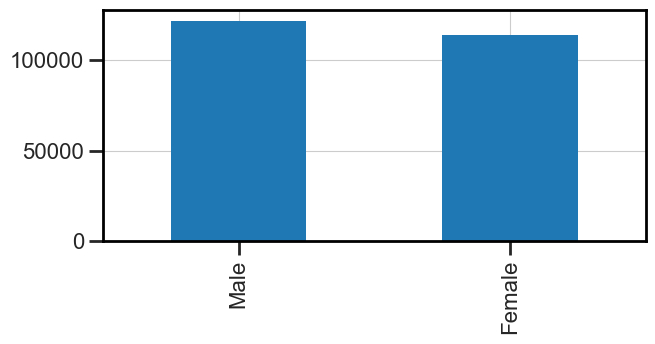

In [12]:
# Gender distribution
df["SEX"].value_counts().plot(kind="bar", figsize= (7,3))
(df["SEX"].value_counts()/df["SEX"].count())*100

White       73.181485
Black       19.034054
Asian        2.465101
Mixed        2.045843
Native       1.611748
Other        1.592671
Islander     0.069099
Name: RAC1P, dtype: float64

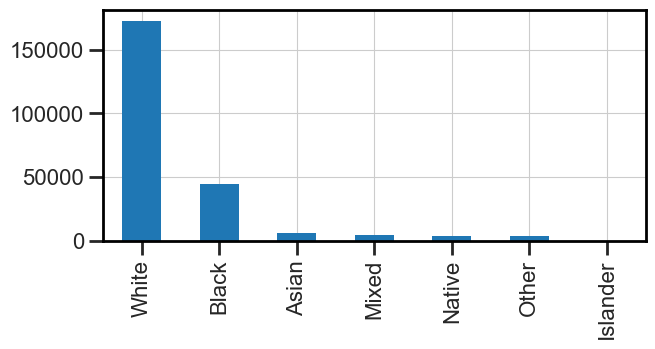

In [13]:
# Race distribution
df["RAC1P"].value_counts().plot(kind="bar", figsize= (7,3))
(df["RAC1P"].value_counts()/df["RAC1P"].count())*100

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


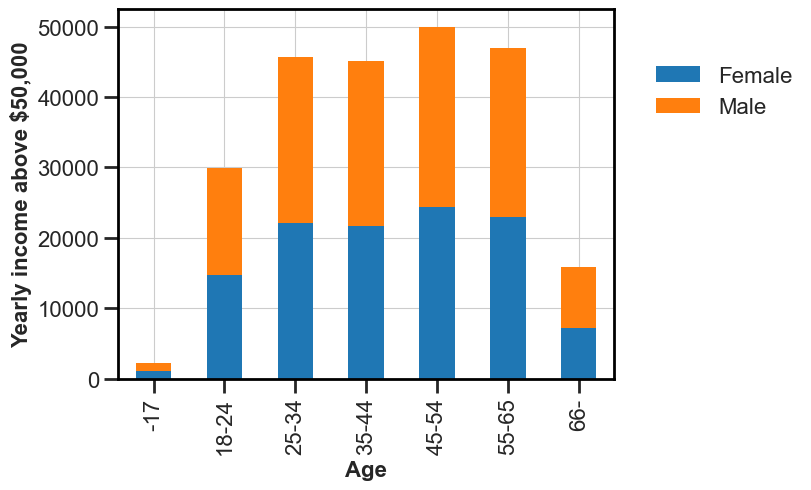

In [14]:
# Age distribution
df_ag = df.groupby(['AGE', 'SEX'])['AGE'].count().unstack('SEX').fillna(0)
df_ag.plot(kind='bar', stacked=True)
plt.xlabel('Age', fontweight="bold")
plt.ylabel('Yearly income above $50,000', fontweight="bold")
plt.legend(bbox_to_anchor=(1.4, 0.9))
plt.savefig(resu_path + 'lar_distbyage.pdf', bbox_inches='tight', dpi=400)
plt.show() 

NC    50893
GA    50238
TN    33240
SC    24327
AL    22074
LA    20882
OK    17724
MS    13003
AK     3512
Name: STATE, dtype: int64


50893

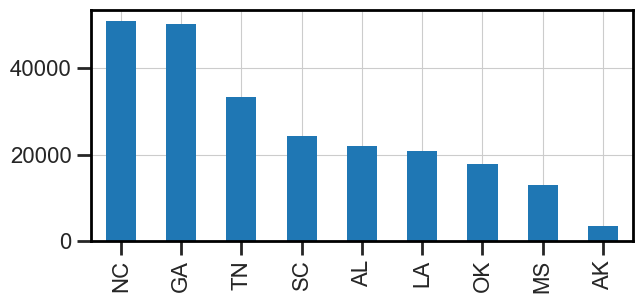

In [15]:
# State distribution
df["STATE"].value_counts().plot(kind="bar", figsize= (7,3))
print(df["STATE"].value_counts())
df["STATE"].value_counts().max()

<AxesSubplot:>

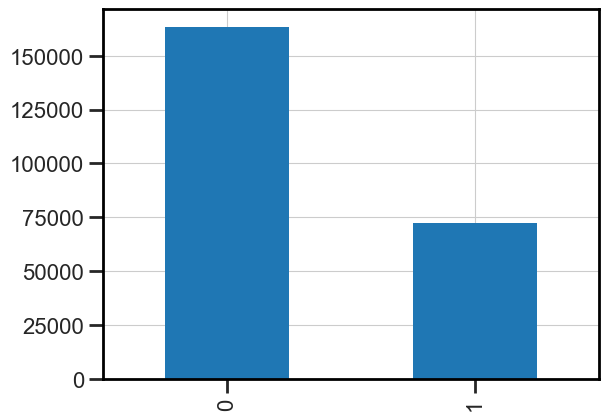

In [16]:
# Target variable distribution
df[target].value_counts()
df[target].value_counts().plot(kind='bar', stacked=True)

(Y          0      1
 AGE                
 -17     2199      6
 18-24  29283    653
 25-34  35921   9737
 35-44  28993  16170
 45-54  29865  20133
 55-65  28088  18954
 66-     9085   6806,
 AGE
 -17       0.272109
 18-24     2.181320
 25-34    21.325945
 35-44    35.803645
 45-54    40.267611
 55-65    40.291654
 66-      42.829274
 dtype: float64)

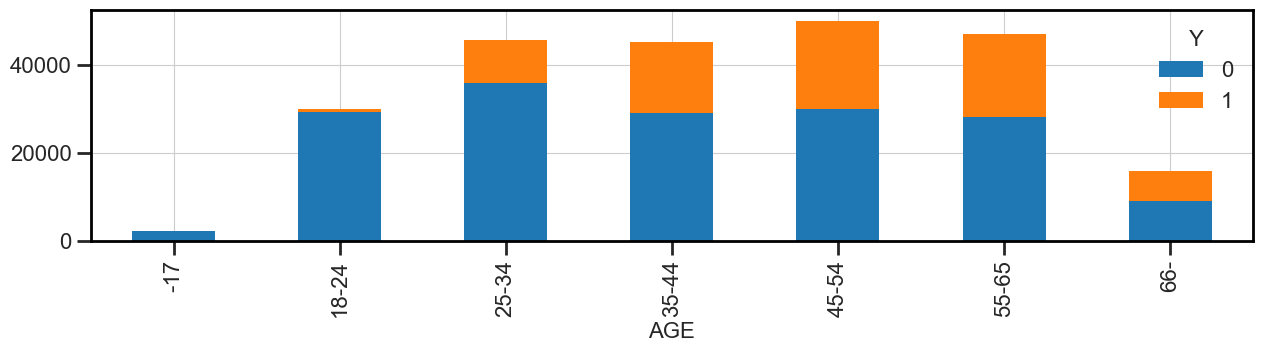

In [17]:
# Distribution of the target variable by Age,
df_ay = df.groupby(['AGE', target])['AGE'].count().unstack(target).fillna(0)
df_ay.plot(kind='bar', stacked=True, figsize= (15,3))
#ratio of leaving (1) employees oer age group
df_ay, (df_ay[1]/(df_ay[0]+df_ay[1])*100).sort_values()

(Y           0      1
 SEX                 
 Female  88449  25723
 Male    74985  46736,
 SEX
 Female    22.530042
 Male      38.396004
 dtype: float64)

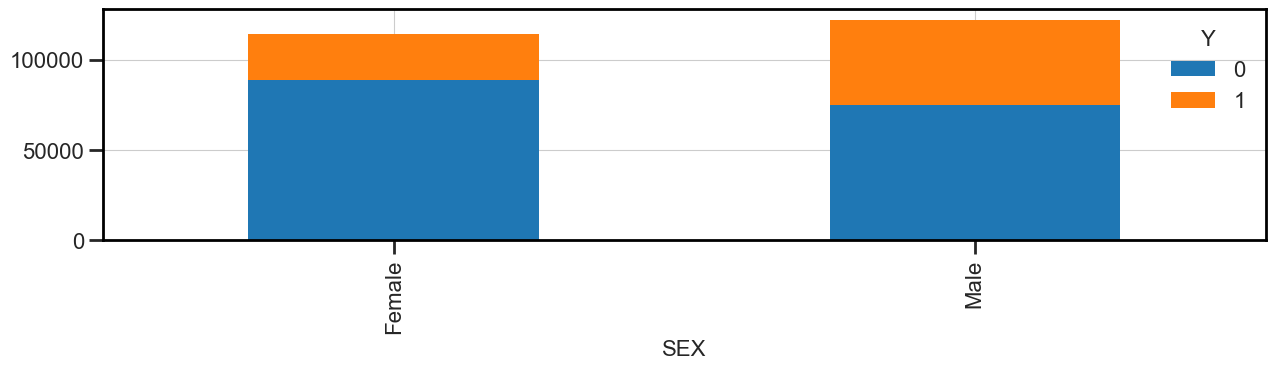

In [18]:
# Distribution of the target variable by Gender
df_gy = df.groupby(['SEX', target])['SEX'].count().unstack(target).fillna(0)
df_gy.plot(kind='bar', stacked=True, figsize= (15,3))
# Ratio of leaving (1) employees oer age group
df_gy, df_gy[1] / (df_gy[0] + df_gy[1])*100

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


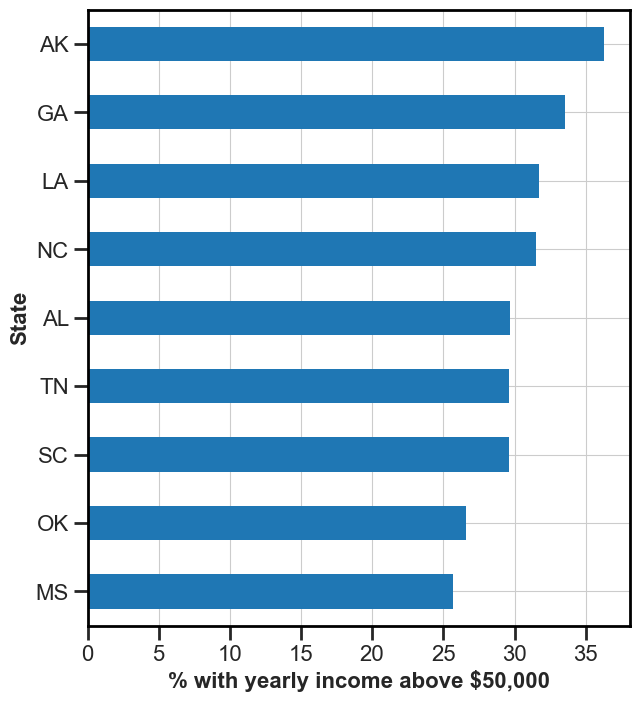

STATE
MS    25.655618
OK    26.624915
SC    29.588523
TN    29.626955
AL    29.686509
NC    31.530859
LA    31.687578
GA    33.572196
AK    36.304100
Name: Y, dtype: float64


In [19]:
# Distribution of the Y target variable per state
percs = (df.groupby('STATE')[target].mean() * 100).sort_values()
percs.plot.barh(grid = True, figsize = (7, 8))
plt.xlabel('% with yearly income above $50,000', fontweight="bold")
plt.ylabel('State', fontweight="bold")
plt.savefig(resu_path + 'lar_distbycountry.pdf', bbox_inches='tight', dpi=400)
plt.show() 
print(percs)

## Feature analysis

In [20]:
# Kruskal test
a = 'STATE'
for b in ['AGEP', 'SCHL', 'OCCP', 'MAR']:
    l = [[*v] for _, v in df[[a,b]].groupby(a)[b]]
    print(b)
    print(stats.kruskal(*l))

AGEP
KruskalResult(statistic=132.19976697139518, pvalue=9.896726030838647e-25)
SCHL
KruskalResult(statistic=1320.5311967483585, pvalue=8.575778523881577e-280)
OCCP
KruskalResult(statistic=559.6859350347287, pvalue=1.0789451698058068e-115)
MAR
KruskalResult(statistic=312.81459599523413, pvalue=7.693955953049199e-63)


meta NOT subset; don't know how to subset; dropped


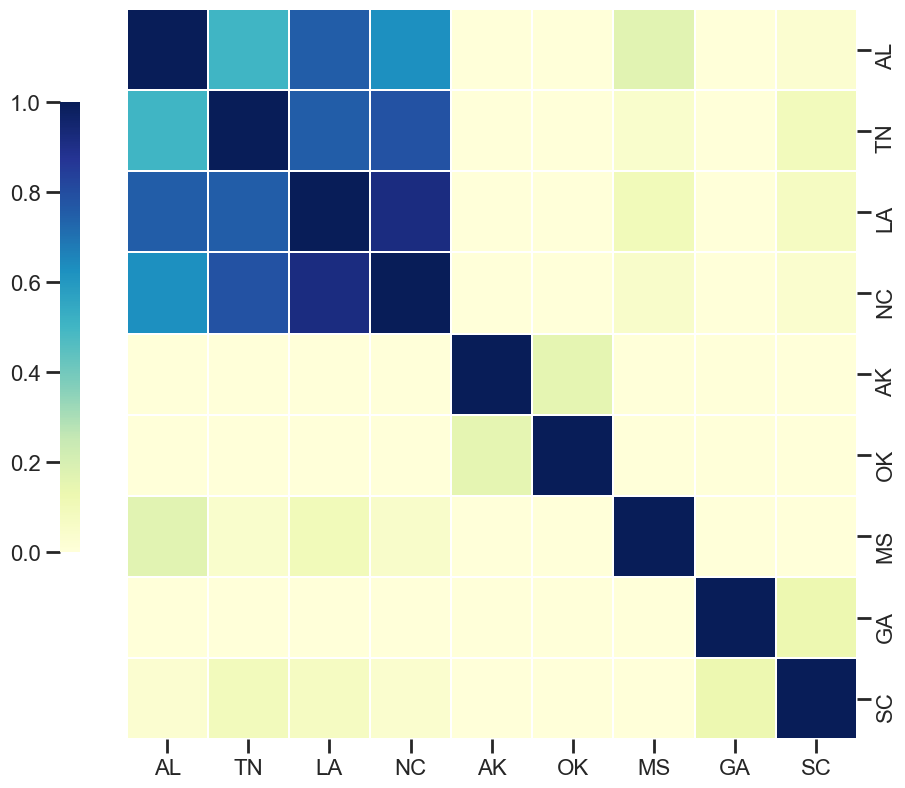

In [21]:
import scikit_posthocs as sp

# post-hoc test
pc = sp.posthoc_conover(df, val_col='AGEP', group_col=a)
cg = sns.clustermap(pc,xticklabels=True, yticklabels = True, linewidths= 0.25, cmap="YlGnBu")
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_position([.14, .25, .02, .45])
cg.cax.yaxis.set_ticks_position("left")
## plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=75) # rotate ticks - not done
plt.savefig(resu_path + 'lar_heatmap.pdf', bbox_inches='tight', dpi=400)

In [22]:
#Feature importance based on average precision of a classifier on the single feature
def test_proc(clf, X, y):
    # something close to: res =cross_val_score(clf, X, y, cv=10, scoring=score_metric)
    res_auc = res_avg = []
    for ite in range(0, 10):
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state=ite)
        for train, test in skf.split(X, y):
                X_train = X.iloc[train]
                y_train = y.iloc[train]
                X_test = X.iloc[test]
                y_test = y.iloc[test]
                clf.fit(X_train, y_train)
                y_scores = clf.predict_proba(X_test)[:,1] 
                avg_pr = average_precision_score(y_test, y_scores, sample_weight=None)
                res_avg.append(avg_pr)
                precision, recall, _ = precision_recall_curve(y_test, y_scores, sample_weight=None)
                auc_pr = auc(recall, precision)           
                res_auc.append(auc_pr)           
    # mean
    m = statistics.mean(res_auc)
    # standard deviation over the folds
    s = statistics.stdev(res_auc)
    # ci lower
    ci = ci_auc(res_avg, npos=sum(y))
    l = ci[2]
    u = ci[3]
    return (m, s, l, u)

In [23]:
#Feature importance using logistic regression on Theme columns
clf = LogisticRegression(solver='lbfgs', random_state=0)
roc = dict()
for b in ['AGEP', 'SCHL', 'OCCP', 'MAR']:
# for b in all_feats:
    m, s, l, u = test_proc(clf, df[[b]], df[target])
    roc[b] = (m, s, l, u)

SCHL: PR AUC=0.533 +/- 0.022 CI=(0.530, 0.535812)
OCCP: PR AUC=0.513 +/- 0.006 CI=(0.512, 0.513814)
MAR: PR AUC=0.504 +/- 0.111 CI=(0.488, 0.519400)
AGEP: PR AUC=0.403 +/- 0.004 CI=(0.403, 0.403946)


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


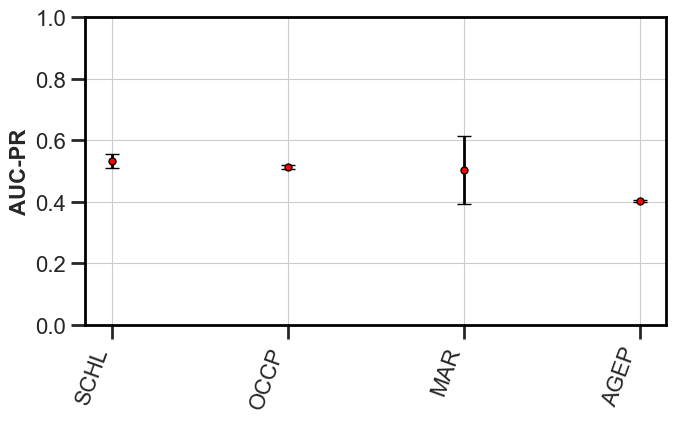

In [24]:
#Plot feature importance for themes
plt.figure(figsize=(7.5,4))
labels = []
i = 1
for b, v in sorted(roc.items(), key=lambda kv: kv[1][0], reverse=True):
    print('%s: PR AUC=%.3f +/- %.3f CI=(%.3f, %3f)' % (b, v[0], v[1], v[2], v[3]))
    plt.errorbar([i], [v[0]], yerr= [ [v[1]], [v[1]] ], c='black', fmt='o', mfc='red', markersize=5, capsize=5) # error bar
#     plt.errorbar([i], [v[0]], yerr= [ [v[0]-v[2]], [v[3]-v[0]] ], c='black', fmt='o', mfc='red', markersize=5, capsize=5) # ci bars
    labels.append(b)
    i += 1
plt.xticks(range(1, i), labels, rotation=70, ha='right')
plt.ylabel('AUC-PR', fontweight="bold")
plt.ylim(0, 1)
plt.savefig(resu_path + 'lar_uniaucpr.pdf', bbox_inches='tight', dpi=400)

## Running the experiments

*Recall:* AGEP (Age); COW (Class of worker); SCHL (Educational attainment); MAR (Marital status); OCCP (Occupation); POBP (Place of birth); RELP (Relationship); WKHP (Usual hours worked per week past 12 months); SEX (Sex); RAC1P (Recoded detailed race code); STATE.

In [25]:
print(df.columns.to_list())
print(all_feats)
print(con_feats)
print(ord_feats)
print(cat_feats)

['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P', 'Y', 'STATE', 'AGE']
['AGEP', 'WKHP', 'COW', 'MAR', 'POBP', 'RELP', 'SEX', 'RAC1P', 'STATE', 'SCHL', 'OCCP']
['AGEP', 'WKHP']
['SCHL', 'OCCP']
['COW', 'MAR', 'POBP', 'RELP', 'SEX', 'RAC1P', 'STATE']


In [26]:
# drop columns
df.drop(columns = ['AGE'], inplace = True)
# all_feats.remove('AGE') # not included before, though: AGEP is already cont.
cat_feats.remove('RELP')
cat_feats.remove('POBP')

In [27]:
# input specific for clf loop (via Optuna)
categorical_columns = ['SEX', 'RAC1P', 'STATE', 'MAR', 'OCCP']

In [28]:
# check which variables are not numeric
df.select_dtypes(exclude = np.number).columns

Index(['SEX', 'RAC1P', 'STATE'], dtype='object')

In [29]:
# encode categorical features
state_encoder = LabelEncoder()
df['STATE'] = state_encoder.fit_transform(df['STATE'])

sex_encoder = LabelEncoder()
df['SEX'] = sex_encoder.fit_transform(df['SEX'])

race_encoder = LabelEncoder()
df['RAC1P'] = race_encoder.fit_transform(df['RAC1P'])

In [30]:
# check which variables are not numeric
df.select_dtypes(exclude = np.number).columns

Index([], dtype='object')

In [31]:
# set weights
weight_column = None
# weight_column = df["Weight"]

# find positive rate
if weight_column is not None:
    print('Positive rate', sum(weight_column[df[target]==1]) / sum(weight_column))
# simulate weights for TABNET
if weight_column is not None:
    simulate_weights = True
else:
    simulate_weights = False

In [32]:
num_repeat = 10

# Amount of trials/hyperparameter configurations per classifier
n_trials = 50

# Number of folds in StratifiedK cross-validation used when evaluating each classifier type
stratified_folds_cv = 10

# Number of cross-validation folds used when evaluating each trial within Optuna
trial_cv = 3

# Classifiers to experiment with
clf_names = ["LGBM2", "LR"]
# clf_names = ["LGBM2", 'LGBM', "LR", "RF", "DT", "XGB", "KNN", "TABNET"]

In [ ]:
import time

# Notes:
# - "LGBM" is lightgbm with specialized optuna_study hyperparameter search (not included in the paper)
# - "LGBM2" is lightgbm with normal optuna_study hyperparameter search
# - AUPR curve computed using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html

# store incrementally the results of experiments
experiment_results = []

# for dataset_version, dataset in datasets.items():
#     print('Dataset version', dataset_version)

dataset_version = 'bible_belt'
dataset = df.copy()

# create our X and y from the selected dataset
X = dataset.copy()
y = dataset[target]
X.drop(columns = [target], inplace = True)
    
# run experiments       
for rep in range(0, num_repeat):
    skf = StratifiedKFold(n_splits = stratified_folds_cv, shuffle = True, random_state=rep)
    
    for fold, (train, test) in enumerate(skf.split(X, y)):
        # train, test contain position based indexes of the sets
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        sw_train = weight_column.iloc[train] if weight_column is not None else None
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        sw_test = weight_column.iloc[test] if weight_column is not None else None
                        
        if simulate_weights:
            X_train = X_train.copy()
            X_train[target] = y_train
            wc = (sw_train/min(sw_train)).astype('int32')
            X_train = X_train.loc[X_train.index.repeat(wc)].reset_index(drop=True)
            y_train = X_train[target]
            X_train.drop(columns = [target], inplace = True)
            sw_train = None
            print(X_train.shape)

        # Try all classifiers
        for clf_name in clf_names:
            
            start = time.time()

            # @Salvatore: since the paper uses LGBM2, should we remove this bit?
            if clf_name == "LGBM":
                # hyperparameter optimization just on the trainset of the fold
                experiment_result = optuna_study_lgbm(categorical_columns, 
                                                      trial_cv, X_train, y_train, sw_train)        
            else:
                # hyperparameter optimization just on the trainset of the fold
                experiment_result = optuna_study_normal(clf_name, 
                                                        categorical_columns, 
                                                        trial_cv, n_trials, X_train, y_train, sw_train)
            
            experiment_result["dataset"] = dataset_version

            # build the model with build_opt_clf(string, dictionary)
            clf = build_model(experiment_result['clf_name'], categorical_columns, experiment_result['best_hyparams'])

            # the model now has to learn the parameters from the training set
            if sw_train is not None:
                clf.fit(X_train, y_train, clf__sample_weight=sw_train)
            else:
                clf.fit(X_train, y_train)

            end = time.time()

            # evaluate the model on the test set: predict_proba returns ndarray of probs of shape (n_samples, n_classes)
            y_scores = clf.predict_proba(X_test)[:,1] 

            # AUPR compares the ground truth with predicted probabilities     
            ap = average_precision_score(y_test, y_scores, sample_weight=sw_test)
            precision, recall, _ = precision_recall_curve(y_test, y_scores, sample_weight=sw_test)
            auc_pr = auc(recall, precision)

            # add to experiment_result dictionary (output of optuna_study) with a new key:value pair (metric_test)
            experiment_result['fold'] = rep*stratified_folds_cv+fold
            experiment_result['auc_pr_test'] = auc_pr
            experiment_result['ap_test'] = ap
            experiment_result['elapsed'] = end - start
            experiment_result['clf'] = clf
            experiment_result['train'] = train
            experiment_result['test'] = test

            # add the dictionary to the experiment_results list
            experiment_results.append(experiment_result)

            print(dataset_version, clf_name, 'fold', experiment_result['fold'], 'metrics', auc_pr, ap, end - start)

print('DONE')